In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import gym

from statistics import median, mean
from collections import Counter

In [2]:
env = gym.make('CartPole-v0')

In [3]:
# Each of these is its own game.
for episode in range(5):
    env.reset()
    # this is each frame, up to 200...but we wont make it that far.
    for t in range(400):
        # This will display the environment
        # Only display if you really want to see it.
        # Takes much longer to display it.            
        env.render()
        
        # This will just create a sample action in any environment.
        # In this environment, the action can be 0 or 1, which is left or right
        action = env.action_space.sample()
            
        # this executes the environment with an action, 
        # and returns the observation of the environment, 
        # the reward, if the env is over, and other info.
        observation, reward, done, info = env.step(action)
        # OBS: [Position of cart, angle of pole, derivtive of position, derivative of angle].
            
env.close()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
initial_games = 10000
goal_steps = 500
score_requirement = 50

In [21]:
def generate_games():
    # [OBS, MOVES]
    training_data = []
    # all scores:
    scores = []
    # just the scores that met our threshold:
    accepted_scores = []
    # iterate through however many games we want:
    for _ in range(initial_games):
        score = 0
        # moves specifically from this environment:
        game_memory = []
        # previous observation that we saw
        prev_observation = []
        # for each frame in 200
        for _ in range(goal_steps):
            # choose random action (0 or 1)
            action = random.randrange(0,2)
            # do it!
            observation, reward, done, info = env.step(action)
            
            # notice that the observation is returned FROM the action
            # so we'll store the previous observation here, pairing
            # the prev observation to the action we'll take.
            # We pair the both the action and observation at time t. 
            if len(prev_observation) > 0 :
                game_memory.append([prev_observation, action])
            prev_observation = observation
            score+=reward
            if done: break

        # IF our score is higher than our threshold, we'd like to save
        # every move we made
        # NOTE the reinforcement methodology here. 
        # all we're doing is reinforcing the score, we're not trying 
        # to influence the machine in any way as to HOW that score is 
        # reached.
        if score >= score_requirement:
            accepted_scores.append(score)
            for data in game_memory:
                # convert to one-hot (this is the output layer for our neural network)
                if data[1] == 1:
                    output = [0, 1]
                elif data[1] == 0:
                    output = [1, 0]
                    
                # saving our training data [OBS, One-Hot-Encoded action]
                training_data.append([data[0], output])

        # reset env to play again
        env.reset()
        # save overall scores
        scores.append(score)
    
    # just in case you wanted to reference later
    training_data_save = np.array(training_data)
    np.save('saved.npy',training_data_save)
    
    # some stats here, to further illustrate the neural network magic!
    print('Average accepted score:', mean(accepted_scores))
    print('Median score for accepted scores:',median(accepted_scores))
    print(Counter(accepted_scores))
    
    return training_data, Counter(accepted_scores)

In [22]:
training_data, accepted_scores = generate_games()

Average accepted score: 62.07297297297297
Median score for accepted scores: 58.0
Counter({50.0: 38, 52.0: 26, 53.0: 26, 51.0: 20, 54.0: 19, 56.0: 18, 57.0: 16, 65.0: 14, 55.0: 13, 59.0: 13, 58.0: 12, 64.0: 11, 69.0: 9, 61.0: 9, 60.0: 8, 66.0: 8, 72.0: 8, 67.0: 8, 62.0: 8, 70.0: 7, 68.0: 7, 76.0: 7, 63.0: 6, 71.0: 5, 79.0: 5, 82.0: 4, 81.0: 4, 75.0: 3, 84.0: 3, 83.0: 3, 74.0: 3, 89.0: 3, 73.0: 3, 80.0: 3, 77.0: 2, 90.0: 2, 97.0: 2, 86.0: 2, 93.0: 2, 101.0: 1, 126.0: 1, 91.0: 1, 99.0: 1, 88.0: 1, 95.0: 1, 78.0: 1, 94.0: 1, 96.0: 1, 87.0: 1})


<BarContainer object of 48 artists>

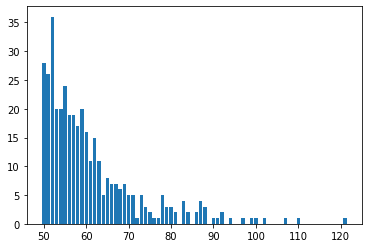

In [7]:
%matplotlib inline
plt.bar(accepted_scores.keys(), accepted_scores.values())

In [8]:
# Model.
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, input_shape=[1, 4], activation=tf.nn.relu),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 128)            640       
_________________________________________________________________
dense_1 (Dense)              (None, 1, 256)            33024     
_________________________________________________________________
dense_2 (Dense)              (None, 1, 128)            32896     
_________________________________________________________________
dense_3 (Dense)              (None, 1, 2)              258       
Total params: 66,818
Trainable params: 66,818
Non-trainable params: 0
_________________________________________________________________


In [10]:
X = tf.convert_to_tensor([tf.expand_dims(d[0], 0) for d in training_data], dtype=tf.float32)
y = tf.convert_to_tensor([i[1] for i in training_data], dtype=tf.float32)

In [11]:
X = X[:20000]
y = y[:20000]

In [12]:
train_ds = tf.data.Dataset.from_tensor_slices((X, y)).batch(1)

In [20]:
feature, target = next(iter(train_ds))
feature[0]

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.03783184,  0.15936837, -0.04896386, -0.34330508]],
      dtype=float32)>

In [14]:
optimizer = tf.keras.optimizers.Adam(1e-3)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

In [15]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [16]:
print(model(tf.expand_dims(feature[0], 0), training=True).numpy())

[[[0.48698846 0.5130115 ]]]


In [17]:
model.fit(train_ds, epochs=5, steps_per_epoch=500)

Train for 500 steps
Epoch 1/5
500/500 [==============================] - 1s 2ms/step - loss: 0.6716 - accuracy: 0.6000
Epoch 2/5
500/500 [==============================] - 1s 1ms/step - loss: 0.6887 - accuracy: 0.5760
Epoch 3/5
500/500 [==============================] - 1s 1ms/step - loss: 0.6816 - accuracy: 0.5820
Epoch 4/5
500/500 [==============================] - 1s 1ms/step - loss: 0.6742 - accuracy: 0.5700
Epoch 5/5
500/500 [==============================] - 1s 1ms/step - loss: 0.6644 - accuracy: 0.6380


In [18]:
#model(tf.expand_dims(feature[0], 0))
model.predict(tf.expand_dims(feature[0], 0))

array([[[0.8965654 , 0.10343464]]], dtype=float32)

In [165]:
env.reset()
obs, reward, done, _ = env.step(env.action_space.sample())
tf.cast(tf.reshape(obs, [1, 1, -1]), tf.float32)

<tf.Tensor: shape=(1, 1, 4), dtype=float32, numpy=
array([[[ 0.0208274 ,  0.22764194,  0.02892191, -0.2985553 ]]],
      dtype=float32)>

In [19]:
for game in range(10):
    score = 0
    prev_obs = []
    env.reset()
    for _ in range(500):
        env.render()
        # Since we don't have a previous observation we have no choice
        # but to intially make a random action.
        if len(prev_obs) == 0:
            action = random.randrange(0, 2)
        else:
            prepared_obs = tf.cast(tf.reshape(prev_obs, [1, 1, -1]), tf.float32)
            # Note: output is onehot encoded vector [0.43, 0.57]. Hence 'Right'.
            action = np.argmax(model(prepared_obs))
        # Get observation, rewards etc... from the next state with respect to the action
        # our model has predicted.
        new_observation, reward, done, info = env.step(action)
        prev_obs = new_observation
        score += reward
        
        if done: break
    
env.close()